## Image Captioning with Pytorch

The following contents are modified from MDS DSCI 575 lecture 8 demo

In [1]:
import os
import json
from collections import defaultdict
from tqdm import tqdm
import pickle
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from torchsummary import summary
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

from nltk.translate import bleu_score
from gensim.models import KeyedVectors

START = "startseq"
STOP = "endseq"
EPOCHS = 10
AWS = True

In [2]:
torch.manual_seed(123)
np.random.seed(123)
# torch.manual_seed(158974)
# np.random.seed(4056)

In [3]:
# torch.cuda.empty_cache()
# import gc 
# gc.collect()

The following function is used to nicely format elapsed times.

In [4]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

### Google CoLab or AWS

In [5]:
if AWS:
    root_captioning = "../../s3"
else:
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        root_captioning = "/content/drive/My Drive/data"
        COLAB = True
        print("Note: using Google CoLab")
    except:
        print("Note: not using Google CoLab")
        COLAB = False

### Clean/Build Dataset

- Read captions
- Preprocess captions


In [6]:
def get_img_info(name, num=np.inf):
    """
    Returns img paths and captions

    Parameters:
    -----------
    name: str
        the json file name
    num: int (default: np.inf)
        the number of observations to get

    Return:
    --------
    list, dict, int
        img paths, corresponding captions, max length of captions
    """
    img_path = []
    caption = [] 
    max_length = 0
    if AWS:
        with open(f'{root_captioning}/json/{name}.json', 'r') as json_data:
            data = json.load(json_data)
            for filename in data.keys():
                if num is not None and len(caption) == num:
                    break
                img_path.append(
                    f'{root_captioning}/{name}/{filename}'
                )
                sen_list = []
                for sentence in data[filename]['sentences']:
                    max_length = max(max_length, len(sentence['tokens']))
                    sen_list.append(sentence['raw'])

                caption.append(sen_list)    
    else:            
        with open(f'{root_captioning}/interim/{name}.json', 'r') as json_data:
            data = json.load(json_data)
            for set_name in ['rsicd', 'ucm']:
                for filename in data[set_name].keys():
                    if num is not None and len(caption) == num:
                        break

                    img_path.append(
                        f'{root_captioning}/raw/imgs/{set_name}/{filename}'
                    )
                    sen_list = []
                    for sentence in data[set_name][filename]['sentences']:
                        max_length = max(max_length, len(sentence['tokens']))
                        sen_list.append(sentence['raw'])

                    caption.append(sen_list)
    
    return img_path, caption, max_length            


In [7]:
# get img path and caption list
# only test 800 train samples and 200 valid samples
# train_paths, train_descriptions, max_length_train = get_img_info('train', 800)
# test_paths, test_descriptions, max_length_test = get_img_info('valid', 200)

train_paths, train_descriptions, max_length_train = get_img_info('train')
test_paths, test_descriptions, max_length_test = get_img_info('valid')
max_length = max(max_length_train, max_length_test)

      
lex = set()
for sen in train_descriptions:
    [lex.update(d.split()) for d in sen]

for sen in test_descriptions:
    [lex.update(d.split()) for d in sen]


Stats on what was collected.

In [8]:
print(len(train_descriptions)) # How many images? 
print(len(test_descriptions)) # How many images? 
print(len(lex)) # How many unique words (vocab)
print(max_length) # Maximum length of a caption (in words)


8332
2084
2912
34


Display the size of the train and test sets.

In [9]:
print(len(train_paths))
print(len(test_paths))

8332
2084


In [10]:
train_paths[0]

'../../s3/train/ucm_1080.jpg'

Build the sequences.  We include a **start** and **stop** token at the beginning/end.  We will later use the **start** token to begin the process of generating a caption.  Encountering the **stop** token in the generated text will let us know we are done.

In [11]:
for v in train_descriptions: 
    for d in range(len(v)):
        v[d] = f'{START} {v[d]} {STOP}'

See how many discriptions were extracted.

In [12]:
train_descriptions[0]

['startseq Lots of boats docked at the harbor and the boats are closed to each other . endseq',
 'startseq Lots of boats docked neatly at the harbor . endseq',
 'startseq Many boats docked neatly at the harbor and the water is deep blue . endseq',
 'startseq Many boats docked neatly at the harbor and some positions are free . endseq',
 'startseq Lots of boats docked neatly at the harbor and the boats are closed to each other . endseq']

In [13]:
all_train_captions = []
for val in train_descriptions:
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

41660

In [14]:
all_train_captions[0]

'startseq Lots of boats docked at the harbor and the boats are closed to each other . endseq'

Words that do not occur very often can be misleading to neural network training.  It is better to simply remove such words.  Here we remove any words that occur less than 10 times.  We display what the total vocabulary shrunk to.

In [15]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 2704 ==> 901


Next we build two lookup tables for this vocabulary. One idxtoword convers index numbers to actual words to index values.  The wordtoidx lookup table performs the opposit.

In [16]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

902

Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

In [17]:
max_length +=2
print(max_length)

36


In [18]:
# word_model = KeyedVectors.load_word2vec_format(f'{root_captioning}/freebase-vectors-skipgram1000.bin', binary=True)

In [19]:
# word_model.vocab

### Loading Wikipedia2vec Embeddings

In [20]:
# read the embedding matrix 
with open(f'{root_captioning}/enwiki_20180420_2338_words_500d.json', 'r', encoding='utf-8') as file:
    embeddings_index = json.load(file)

In [21]:
embedding_dim = 500

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
count =0
for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        count += 1
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = np.array(embedding_vector)

print(f'{count} out of {vocab_size} words are found in the pre-trained matrix.')

810 out of 902 words are found in the pre-trained matrix.


In [22]:
embedding_matrix.shape

(902, 500)

### Loading Glove Embeddings

In [23]:
# embeddings_index = {} 
# path = os.path.join(root_captioning, 'glove.6B.200d.txt') if AWS\
# else os.path.join(root_captioning, 'raw', 'glove.6B.200d.txt')

# f = open(
#     path, 
#     encoding="utf-8"
# )

# for line in tqdm(f):
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs

# f.close()
# print(f'Found {len(embeddings_index)} word vectors.')

In [24]:
# # Get dense vector for each of the 10000 words in out vocabulary
# embedding_matrix = np.zeros((vocab_size, embedding_dim))

# for word, i in wordtoidx.items():
#     #if i < max_words:
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # Words not found in the embedding index will be all zeros
#         embedding_matrix[i] = embedding_vector

In [25]:
# embedding_matrix.shape

### Building the Neural Network

An embedding matrix is built from Glove.  This will be directly copied to the weight matrix of the neural network.

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
class CNNModel(nn.Module):

    def __init__(self, pretrained=True):
        """
        Initializes a CNNModel

        Parameters:
        -----------
        pretrained: bool (default: True)
            use pretrained model if True

        """

        super(CNNModel, self).__init__()

        # inception v3 expects (299, 299) sized images
        self.model =\
        models.inception_v3(
            pretrained=pretrained,
            aux_logits=False
        )
        
        # remove the classification layer
        self.model =\
        nn.Sequential(
            *(list(self.model.children())[: 3]),
            nn.MaxPool2d(kernel_size=3, stride=2),
            *(list(self.model.children())[3: 5]),
            nn.MaxPool2d(kernel_size=3, stride=2),
            *(list(self.model.children())[5: -1])
        )

        self.input_size = 299

    def forward(self, img_input, train=False):
        """
        forward of the CNNModel

        Parameters:
        -----------
        img_input: torch.Tensor
            the image matrix
        train: bool (default: False)
            use the model only for feature extraction if False

        Return:
        --------
        torch.Tensor
            image feature matrix
        """
        if not train:
          # set the model to evaluation model
          self.model.eval()

        # N x 3 x 299 x 299
        features = self.model(img_input)
        # N x 2048 x 8 x 8

        return features

In [28]:
class AttentionModel(nn.Module):

    def __init__(self, feature_size, hidden_size=256):
        """
        Initializes a AttentionModel

        Parameters:
        -----------
        cnn_type: str
            the CNN type, either 'vgg16' or 'inception_v3'
        pretrained: bool (default: True)
            use pretrained model if True

        """

        super(AttentionModel, self).__init__()

        self.W_a = nn.Linear(hidden_size, hidden_size)
        self.v_a = nn.Parameter(torch.rand(hidden_size))

    def forward(self, img_features, h):
        """
        forward of the AttentionModel

        Parameters:
        -----------
        img_input: torch.Tensor
            the image matrix
        train: bool (default: False)
            use the model only for feature extraction if False

        Return:
        --------
        torch.Tensor
            image feature matrix
        """

        # N = batch_size
        batch_size = img_features.size(0)

        # 1 x N x hidden_size
        h_a = h.repeat(img_features.size(1), 1, 1).permute(1, 0, 2)
        # N x 64 x hidden_size

        # attention scoring function v_a(tanh(W_a[s;h]))
        # tanh(W_a[s;h])
        energy =\
        torch.tanh(
            self.W_a(
                h_a + img_features
#                 torch.cat((h_a, img_features), dim = 2)
            )
        ).permute(0, 2, 1)
        # N x hidden_size x 64

        # hidden_size
        v = self.v_a.repeat(batch_size, 1).unsqueeze(1)
        # N x 1 x hidden_size

        # v_a(tanh(W_a[s;h]))
        # torch.bmm takes 3D tensors
        attention = torch.bmm(v, energy)
        # N x 1 x 64

        attention_weights = F.softmax(attention, dim=2)
        # N x 1 x 64

        return attention_weights

In [29]:
class RNNModel(nn.Module):

    def __init__(
        self, 
        feature_size,
        vocab_size,
        embedding_dim, 
        hidden_size=256,
        embedding_matrix=None, 
        embedding_train=False
    ):
      
        """
        Initializes a RNNModel

        Parameters:
        -----------
        feature_size: int
            the number of features in the image matrix
        vocab_size: int
            the size of the vocabulary
        embedding_dim: int
            the number of features in the embedding matrix
        hidden_size: int (default: 256)
            the size of the hidden state in LSTM
        embedding_matrix: torch.Tensor (default: None)
            if not None, use this matrix as the embedding matrix
        embedding_train: bool (default: False)
            not train the embedding matrix if False
        """

        super(RNNModel, self).__init__()

        self.feature_size = feature_size
        self.hidden_size = hidden_size

        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

        self.out_dense = nn.Linear(hidden_size, hidden_size)
        self.h_dense = nn.Linear(feature_size, hidden_size)
        self.c_dense = nn.Linear(feature_size, hidden_size)  
        self.img_dense = nn.Linear(feature_size, hidden_size)
        
        self.embedding =\
        nn.Embedding(vocab_size,embedding_dim, padding_idx=0)

        if embedding_matrix is not None:

            self.embedding.load_state_dict({
                'weight': torch.FloatTensor(embedding_matrix)
            })
            self.embedding.weight.requires_grad = embedding_train

        self.attention =\
        AttentionModel(feature_size, hidden_size)
        
        self.lstm =\
        nn.LSTM(hidden_size, hidden_size, batch_first=True)
      

    def forward(self, img_features, captions):
        """
        forward of the RNNModel

        Parameters:
        -----------
        img_features: torch.Tensor 
            the image feature matrix
            (N x feature_size(2048) x 8 x 8)
        captions: torch.Tensor 
            the padded caption matrix
            (N x seq_len)

        Return:
        --------
        torch.Tensor
            word probabilities for each position
        """

        # N = batch_size
        batch_size = captions.size(0)
        seq_len = captions.size(1)

        # N x feature_size(2048) x 8 x 8
        img_features =\
        img_features.view(
            batch_size, self.feature_size, -1
        ).permute(0, 2, 1)
        # N x 64 x feature_size(2048)

        # N x 64 x feature_size(2048)
        h = self.h_dense(img_features.mean(dim=1)).unsqueeze(0)
        c = self.c_dense(img_features.mean(dim=1)).unsqueeze(0)
        # 1 x N x hidden_size
       
        # N x feature_size(2048) x 8 x 8
        img_features =\
        self.relu(
            self.img_dense(
                self.dropout(
                    img_features
                )
            )
        )  
        # N x 64 x hidden_size

        # N x seq_len
        embed =\
        self.dropout(
            self.embedding(
                captions
            )
        )
        # N x seq_len x embedding_dim
        
        outputs =\
        torch.zeros(
            batch_size,
            seq_len, 
            self.hidden_size
        ).to(device)

        all_attention_weights =\
        torch.zeros(
            batch_size,
            seq_len, 
            img_features.shape[1]
        ).to(device)
        
        for i in range(seq_len):

            attention_weights = self.attention(img_features, h)
            # N x 1 x 64

            # weighted sum of img_features
            weighted = torch.bmm(attention_weights, img_features)
            # N x 1 x hidden_size

            output, (h, c) =\
            self.lstm(
                embed[:, i, :].unsqueeze(1) + weighted,
                (h, c)
            )
            # outputs: N x 1 x hidden_size
            # h: 1 x N x hidden_size
            # c: 1 x N x hidden_size

            output =\
            self.out_dense(
                output.squeeze(1) + weighted.squeeze(1) + embed[:, i, :]
            )
            # N x hidden_size
 
            outputs[:, i, :] = output.squeeze()
            all_attention_weights[:, i, :] = attention_weights.squeeze()

        return outputs, all_attention_weights



In [30]:
class CaptionModel(nn.Module):

    def __init__(
        self, 
        vocab_size, 
        embedding_dim, 
        hidden_size=256,
        embedding_matrix=None, 
        embedding_train=False
    ):

        """
        Initializes a CaptionModel

        Parameters:
        -----------
        vocab_size: int
            the size of the vocabulary
        embedding_dim: int
            the number of features in the embedding matrix
        hidden_size: int (default: 256)
            the size of the hidden state in LSTM
        embedding_matrix: torch.Tensor (default: None)
            if not None, use this matrix as the embedding matrix
        embedding_train: bool (default: False)
            not train the embedding matrix if False
        """    
        super(CaptionModel, self).__init__() 

        # set feature_size based on cnn_type
        self.feature_size = 2048

        self.decoder = RNNModel(
            self.feature_size,
            vocab_size, 
            embedding_dim,
            hidden_size,
            embedding_matrix,
            embedding_train
        )

        self.relu = nn.ReLU()
        self.dense = nn.Linear(hidden_size, vocab_size) 

    # def forward(self, captions):
    def forward(self, img_features, captions):
        """
        forward of the CaptionModel

        Parameters:
        -----------
        img_features: torch.Tensor 
            the image feature matrix
            (N x feature_size(2048) x 8 x 8)
        captions: torch.Tensor 
            the padded caption matrix
            (N x seq_len)

        Return:
        --------
        torch.Tensor
            word probabilities for each position
        """

        decoder_out, all_attention_weights = self.decoder(img_features, captions)

        # add up decoder outputs and image features
        outputs =\
        self.dense(
            self.relu(
                decoder_out
            )
        )

        return outputs, all_attention_weights

### Train the Neural Network

In [31]:
def train(model, iterator, optimizer, criterion, clip):
    """
    train the CaptionModel

    Parameters:
    -----------
    model: CaptionModel
        a CaptionModel instance
    iterator: torch.utils.data.dataloader
        a PyTorch dataloader
    optimizer: torch.optim
        a PyTorch optimizer 
    criterion: nn.CrossEntropyLoss
        a PyTorch criterion 

    Return:
    --------
    float
        average loss
    """
    model.train()    
    epoch_loss = 0
    
    # for captions in iterator:
    for img_features, captions in iterator:
        
        optimizer.zero_grad()

        # for each caption, the end word is not passed for training
        outputs, all_attention_weights = model(
            img_features.to(device),
            captions[:, :-1].to(device)
        )

        loss = criterion(
            outputs.view(-1, vocab_size), 
            captions[:, 1:].flatten().to(device)
        ) + ((1. - all_attention_weights.sum(dim=1)) ** 2).mean()
        epoch_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        
    return epoch_loss / len(iterator)

In [32]:
class SampleDataset(Dataset):
    def __init__(
        self,
        descriptions,
        imgs,
        wordtoidx,
        max_length
    ):
        """
        Initializes a SampleDataset

        Parameters:
        -----------
        descriptions: list
            a list of captions
        imgs: numpy.ndarray
            the image features
        wordtoidx: dict
            the dict to get word index
        max_length: int
            all captions will be padded to this size
        """        
        self.imgs = imgs
        self.descriptions = descriptions
        self.wordtoidx = wordtoidx
        self.max_length = max_length

    def __len__(self):
        """
        Returns the batch size

        Return:
        --------
        int
            the batch size
        """
        # return len(self.descriptions)
        return len(self.imgs)

    def __getitem__(self, idx):
        """
        Prepare data for each image

        Parameters:
        -----------
        idx: int
          the index of the image to process

        Return:
        --------
        list, list, list
            [5 x image feature matrix],
            [five padded captions for this image]
            [the length of each caption]
        """

        img = self.imgs[idx // 5]
        # convert each word into a list of sequences.
        seq = [wordtoidx[word] for word 
               in self.descriptions[idx // 5][idx % 5].split(' ')
               if word in self.wordtoidx]
        # pad the sequence with 0 on the right side
        in_seq = np.pad(
            seq, 
            (0, max_length - len(seq)),
            mode='constant',
            constant_values=(0, 0)
            )

        return img, in_seq


In [33]:
def init_weights(model, embedding_pretrained=True):
    """
    Initialize weights and bias in the model

    Parameters:
    -----------
    model: CaptionModel
      a CaptionModel instance
    embedding_pretrained: bool (default: True)
        not initialize the embedding matrix if True
    """  
  
    for name, param in model.named_parameters():
        if embedding_pretrained and 'embedding' in name:
            continue
        elif 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            

In [34]:
def encode_image(model, img_path):
    """
    Process the images to extract features

    Parameters:
    -----------
    model: CNNModel
      a CNNModel instance
    img_path: str
        the path of the image
 
    Return:
    --------
    torch.Tensor
        the extracted feature matrix from CNNModel
    """  

    img = Image.open(img_path)

    # Perform preprocessing needed by pre-trained models
    preprocessor = transforms.Compose([
        transforms.Resize(model.input_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    img = preprocessor(img)
    # Expand to 2D array
    img = img.view(1, *img.shape)
    # Call model to extract the smaller feature set for the image.
    x = model(img.to(device), False) 
    # Shape to correct form to be accepted by LSTM captioning network.
    x = np.squeeze(x)
    return x

In [35]:
def extract_img_features(img_paths, file_path, model=None):
    """
    Extracts, stores and returns image features

    Parameters:
    -----------
    img_paths: list
        the paths of images
    file_path: str
        the path to store the results
    model: CNNModel (default: None)
      a CNNModel instance

    Return:
    --------
    numpy.ndarray
        the extracted image feature matrix from CNNModel
    """ 

    if not os.path.exists(file_path):
        if model is None:
            raise Exception("Please pass a CNNModel instance.")
        start = time()
        img_features = []
        
        for image_path in tqdm(img_paths):
            img_features.append(
                encode_image(model, image_path).cpu().data.numpy()
            )
      
        with open(file_path, "wb") as fp:
            pickle.dump(img_features, fp)

        print(f"\nGenerating set took: {hms_string(time()-start)}")

    else:
        with open(file_path, "rb") as fp:
            img_features = pickle.load(fp)

    return img_features

In [36]:
# caption_model = CaptionModel(
#     vocab_size, 
#     embedding_dim=1024, 
#     hidden_size=1024,
#     embedding_matrix=None, 
#     embedding_train=True
# )


# caption_model.to(device)

# init_weights(
#     caption_model,
#     embedding_pretrained=False
# )


In [37]:
caption_model = CaptionModel(
    vocab_size, 
    embedding_dim=embedding_dim, 
    hidden_size=500,
    embedding_matrix=embedding_matrix, 
    embedding_train=True
)


init_weights(
    caption_model,
    embedding_pretrained=True
)

caption_model.to(device)


CaptionModel(
  (decoder): RNNModel(
    (dropout): Dropout(p=0.5, inplace=False)
    (relu): ReLU()
    (out_dense): Linear(in_features=500, out_features=500, bias=True)
    (h_dense): Linear(in_features=2048, out_features=500, bias=True)
    (c_dense): Linear(in_features=2048, out_features=500, bias=True)
    (img_dense): Linear(in_features=2048, out_features=500, bias=True)
    (embedding): Embedding(902, 500, padding_idx=0)
    (attention): AttentionModel(
      (W_a): Linear(in_features=500, out_features=500, bias=True)
    )
    (lstm): LSTM(500, 500, batch_first=True)
  )
  (relu): ReLU()
  (dense): Linear(in_features=500, out_features=902, bias=True)
)

In [40]:
cnn_type = 'inception_v3'
encoder = CNNModel(pretrained=True)
encoder.to(device)


CNNModel(
  (model): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1

In [41]:
train_img_features = extract_img_features(
    train_paths,
    f'{root_captioning}/dq_notebooks/train_111_inc.pkl',
     encoder
)

100%|██████████| 8332/8332 [03:40<00:00, 37.80it/s]



Generating set took: 0:04:07.21


In [44]:
test_img_features = extract_img_features(
    test_paths,
    f'{root_captioning}/dq_notebooks/test_111_inc.pkl',
    encoder
)

100%|██████████| 2084/2084 [00:56<00:00, 36.84it/s]



Generating set took: 0:01:02.60


In [48]:
train_img_features[0].shape

(2048, 8, 8)

In [49]:
## we will ignore the pad token in true target set
criterion = nn.CrossEntropyLoss(ignore_index = 0)

optimizer = torch.optim.Adam(
    caption_model.parameters(), 
    lr=0.01
)

train_dataset = SampleDataset(
    train_descriptions,
    train_img_features,
    wordtoidx,
    max_length
)

train_loader = DataLoader(
    train_dataset,
    1000,
)

In [50]:
clip = 1

model_path = f'{root_captioning}/dq_notebooks/model_111_inc.hdf5'

if not os.path.exists(model_path):
    start = time()

    for i in tqdm(range(EPOCHS * 3)):
        
        loss = train(caption_model, train_loader, optimizer, criterion, clip)
        print(loss)
        
    # reduce the learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = 1e-4

    for i in tqdm(range(EPOCHS * 3)):

        loss = train(caption_model, train_loader, optimizer, criterion, clip)
        print(loss)
        
    torch.save(caption_model, model_path)
    print(f"\Training took: {hms_string(time()-start)}")

else:
    caption_model = torch.load(model_path)


  3%|▎         | 1/30 [00:06<03:14,  6.72s/it]

7.2276650534735785


  7%|▋         | 2/30 [00:13<03:07,  6.70s/it]

4.640562640296088


 10%|█         | 3/30 [00:19<03:00,  6.68s/it]

3.955333842171563


 13%|█▎        | 4/30 [00:26<02:53,  6.66s/it]

3.3234239419301352


 17%|█▋        | 5/30 [00:33<02:46,  6.64s/it]

2.919746345943875


 20%|██        | 6/30 [00:39<02:39,  6.63s/it]

2.6267624961005316


 23%|██▎       | 7/30 [00:46<02:32,  6.62s/it]

2.4332809183332653


 27%|██▋       | 8/30 [00:53<02:25,  6.62s/it]

2.276516728931003


 30%|███       | 9/30 [00:59<02:19,  6.63s/it]

2.1452303330103555


 33%|███▎      | 10/30 [01:06<02:12,  6.63s/it]

2.0272593630684748


 37%|███▋      | 11/30 [01:13<02:06,  6.66s/it]

1.9243565135531955


 40%|████      | 12/30 [01:19<01:59,  6.66s/it]

1.8342641989390056


 43%|████▎     | 13/30 [01:26<01:53,  6.66s/it]

1.7787809239493475


 47%|████▋     | 14/30 [01:32<01:46,  6.65s/it]

1.7157826291190252


 50%|█████     | 15/30 [01:39<01:40,  6.67s/it]

1.652214699321323


 53%|█████▎    | 16/30 [01:46<01:33,  6.67s/it]

1.623773495356242


 57%|█████▋    | 17/30 [01:53<01:26,  6.66s/it]

1.5649974478615656


 60%|██████    | 18/30 [01:59<01:19,  6.67s/it]

1.4775701893700495


 63%|██████▎   | 19/30 [02:06<01:13,  6.65s/it]

1.417432811525133


 67%|██████▋   | 20/30 [02:12<01:06,  6.65s/it]

1.3572805126508076


 70%|███████   | 21/30 [02:19<00:59,  6.65s/it]

1.306591318713294


 73%|███████▎  | 22/30 [02:26<00:53,  6.66s/it]

1.2607480221324496


 77%|███████▋  | 23/30 [02:32<00:46,  6.66s/it]

1.2386981977356806


 80%|████████  | 24/30 [02:39<00:39,  6.64s/it]

1.2415842745039198


 83%|████████▎ | 25/30 [02:46<00:33,  6.66s/it]

1.2340220742755466


 87%|████████▋ | 26/30 [02:52<00:26,  6.66s/it]

1.2040479249424405


 90%|█████████ | 27/30 [02:59<00:19,  6.64s/it]

1.150326708952586


 93%|█████████▎| 28/30 [03:06<00:13,  6.66s/it]

1.107860995663537


 97%|█████████▋| 29/30 [03:12<00:06,  6.66s/it]

1.0723879006173875


  0%|          | 0/30 [00:00<?, ?it/s]

1.058869547314114


  3%|▎         | 1/30 [00:06<03:11,  6.61s/it]

1.023344053162469


  7%|▋         | 2/30 [00:13<03:05,  6.64s/it]

0.9943318433231778


 10%|█         | 3/30 [00:19<02:59,  6.65s/it]

0.9640992946094937


 13%|█▎        | 4/30 [00:26<02:52,  6.65s/it]

0.9507077270083957


 17%|█▋        | 5/30 [00:33<02:46,  6.64s/it]

0.9414644307560391


 20%|██        | 6/30 [00:39<02:39,  6.66s/it]

0.9339067472351922


 23%|██▎       | 7/30 [00:46<02:33,  6.66s/it]

0.9261184864574008


 27%|██▋       | 8/30 [00:53<02:26,  6.64s/it]

0.9237596525086297


 30%|███       | 9/30 [00:59<02:19,  6.65s/it]

0.9218691123856438


 33%|███▎      | 10/30 [01:06<02:13,  6.66s/it]

0.9166877667109171


 37%|███▋      | 11/30 [01:13<02:06,  6.66s/it]

0.9158077041308085


 40%|████      | 12/30 [01:19<01:59,  6.65s/it]

0.913883904616038


 43%|████▎     | 13/30 [01:26<01:53,  6.66s/it]

0.9112259480688307


 47%|████▋     | 14/30 [01:33<01:46,  6.66s/it]

0.906626992755466


 50%|█████     | 15/30 [01:39<01:39,  6.65s/it]

0.9060285488764445


 53%|█████▎    | 16/30 [01:46<01:33,  6.68s/it]

0.90575729476081


 57%|█████▋    | 17/30 [01:53<01:26,  6.67s/it]

0.9029723670747545


 60%|██████    | 18/30 [01:59<01:19,  6.65s/it]

0.9008207122484843


 63%|██████▎   | 19/30 [02:06<01:13,  6.66s/it]

0.8987574974695841


 67%|██████▋   | 20/30 [02:13<01:06,  6.66s/it]

0.8983262976010641


 70%|███████   | 21/30 [02:19<00:59,  6.64s/it]

0.8958258297708299


 73%|███████▎  | 22/30 [02:26<00:53,  6.64s/it]

0.8954499430126615


 77%|███████▋  | 23/30 [02:32<00:46,  6.59s/it]

0.8923382427957323


 80%|████████  | 24/30 [02:39<00:39,  6.55s/it]

0.8924372659789191


 83%|████████▎ | 25/30 [02:45<00:32,  6.53s/it]

0.8897625936402215


 87%|████████▋ | 26/30 [02:52<00:26,  6.53s/it]

0.8882726695802476


 90%|█████████ | 27/30 [02:58<00:19,  6.51s/it]

0.8899804088804457


 93%|█████████▎| 28/30 [03:05<00:12,  6.48s/it]

0.8869602878888448


 97%|█████████▋| 29/30 [03:11<00:06,  6.46s/it]

0.8858340382575989


100%|██████████| 30/30 [03:18<00:00,  6.60s/it]

0.8847598102357652
\Training took: 0:06:37.75



/home/ubuntu/miniconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CaptionModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/miniconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/miniconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AttentionModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Generating Captions

It is important to understand that a caption is not generated with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable length output, such as free-form text, requires multiple calls to the neural network.

The neural network accepts two objects (which are mapped to the input neurons).  The first is the photo.  The second is an ever growing caption.  The caption begins with just the starting token.  The neural network's output is the prediction of the next word in the caption.  This continues until an end token is predicted or we reach the maximum length of a caption.  Each time predict a new word is predicted for the caption.  The word that has the highest probability (from the neural network) is chosen. 

In [51]:
def generateCaption(img_features):
    in_text = START

    for i in range(max_length):

        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = np.pad(sequence, (0, max_length - len(sequence)),
                          mode='constant', constant_values=(0, 0))
        caption_model.eval()
        yhat, _ = caption_model(
            torch.FloatTensor(img_features)\
            .view(-1, *img_features.shape).to(device),
            torch.LongTensor(sequence).view(-1, max_length).to(device)
        )

        yhat = yhat.view(-1, vocab_size).argmax(1)
        word = idxtoword[yhat.cpu().data.numpy()[i]]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1 : -1]
    final = ' '.join(final)
    return final

### Evaluate Performance on Test Data

The caption model performs relativly well on images that are similar to what it trained on.

../../s3/valid/rsicd_park_3.jpg


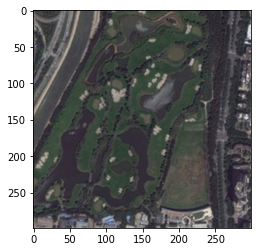

Human-annotated Caption:
 the lake is surrounded by many thick trees .
Generated Caption:
 many green trees and several buildings are around a pond .
BLEU score: 1.3165594234639305e-231
_____________________________________
../../s3/valid/rsicd_mountain_176.jpg


/home/ubuntu/miniconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/miniconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/miniconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

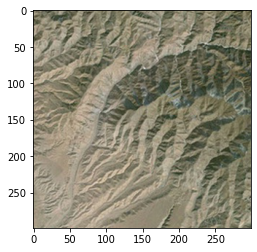

Human-annotated Caption:
 it is a piece of yellow mountain .
Generated Caption:
 it is a piece of khaki mountain .
BLEU score: 0.5946035575013605
_____________________________________
../../s3/valid/rsicd_denseresidential_210.jpg


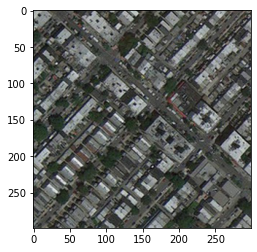

Human-annotated Caption:
 the residential of grey roof buildings is compactly laid out as a whole .
Generated Caption:
 many buildings are in an industrial area .
BLEU score: 6.085166479973199e-232
_____________________________________
../../s3/valid/rsicd_school_163.jpg


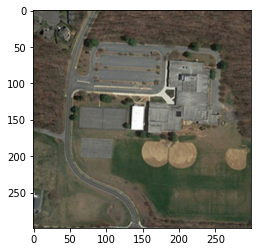

Human-annotated Caption:
 the road through the brown fields and gray building .
Generated Caption:
 a large building with a parking lot is near water .
BLEU score: 1.1896457329133973e-231
_____________________________________
../../s3/valid/ucm_997.jpg


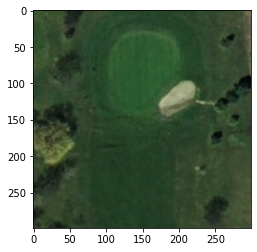

Human-annotated Caption:
 This is a part of a golf course with green turfs and trees .
Generated Caption:
 a building is near several green trees and a pond .
BLEU score: 1.2387700952911024e-231
_____________________________________
../../s3/valid/rsicd_industrial_240.jpg


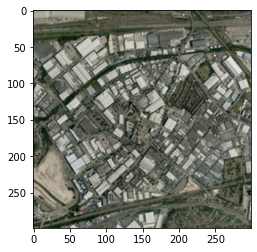

Human-annotated Caption:
 many buildings are in an industrial area .
Generated Caption:
 many buildings and some green trees are in an industrial area .
BLEU score: 0.46924700641055994
_____________________________________
../../s3/valid/rsicd_00613.jpg


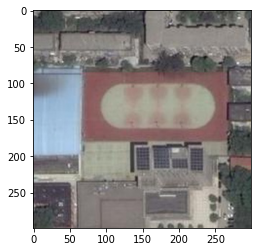

Human-annotated Caption:
 the playground with orange and bright green is next to a a blue building.
Generated Caption:
 a playground is near several buildings .
BLEU score: 5.4227507780138046e-232
_____________________________________
../../s3/valid/ucm_637.jpg


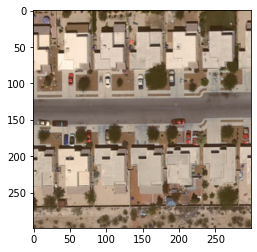

Human-annotated Caption:
 This is a dense residential area .
Generated Caption:
 An intersection with two roads are not vertical to each other .
BLEU score: 9.788429383461836e-232
_____________________________________
../../s3/valid/rsicd_commercial_190.jpg


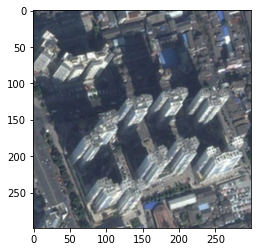

Human-annotated Caption:
 many buildings are in a commercial area .
Generated Caption:
 many buildings and some green trees are in a commercial area .
BLEU score: 0.46924700641055994
_____________________________________
../../s3/valid/rsicd_meadow_94.jpg


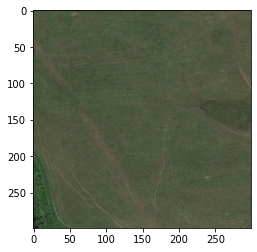

Human-annotated Caption:
 long grass speared out buds .
Generated Caption:
 it is a piece of green meadow .
BLEU score: 1.0832677820940877e-231
_____________________________________
../../s3/valid/rsicd_pond_378.jpg


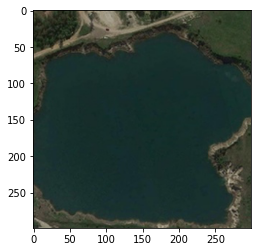

Human-annotated Caption:
 there is a huge lake on the land .
Generated Caption:
 many green trees and meadows are around an irregular pond .
BLEU score: 1.0003688322288243e-231
_____________________________________
../../s3/valid/rsicd_church_233.jpg


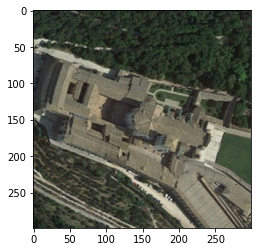

Human-annotated Caption:
 the church is surrounded by dark green trees .
Generated Caption:
 a large number of trees are planted around the square .
BLEU score: 1.3165594234639305e-231
_____________________________________
../../s3/valid/rsicd_playground_97.jpg


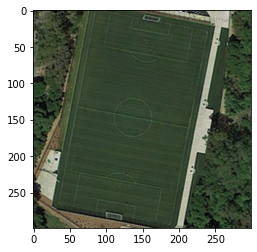

Human-annotated Caption:
 there's a green field on the playground .
Generated Caption:
 a football field is in a playground .
BLEU score: 7.711523862191631e-155
_____________________________________
../../s3/valid/ucm_1254.jpg


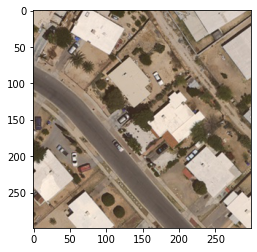

Human-annotated Caption:
 It is a medium residential area with houses arranged neatly .
Generated Caption:
 There are lots of houses arranged neatly and a road goes through them .
BLEU score: 3.1770419500663857e-78
_____________________________________
../../s3/valid/rsicd_bareland_67.jpg


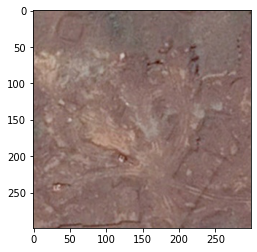

Human-annotated Caption:
 this large bare land area is very broad .
Generated Caption:
 it is a piece of khaki bare land.
BLEU score: 1.1368587676511996e-231
_____________________________________
../../s3/valid/rsicd_farmland_195.jpg


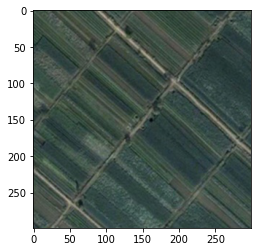

Human-annotated Caption:
 many pieces of farmlands are together .
Generated Caption:
 many pieces of farmlands are together .
BLEU score: 1.0
_____________________________________
../../s3/valid/rsicd_meadow_218.jpg


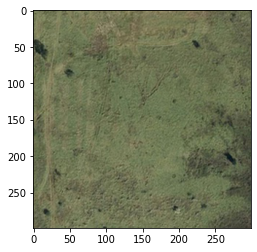

Human-annotated Caption:
 several sparse green trees are in a piece of green meadows .
Generated Caption:
 it is a piece of green meadow .
BLEU score: 0.22172045047934608
_____________________________________
../../s3/valid/rsicd_00275.jpg


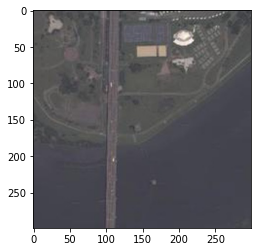

Human-annotated Caption:
 it is obvious that there is a flow of turns where there is a bridge connecting the river on both sides .
Generated Caption:
 a bridge is over a river with a bridge on it and some green trees near it .
BLEU score: 4.802910247043045e-155
_____________________________________
../../s3/valid/rsicd_denseresidential_16.jpg


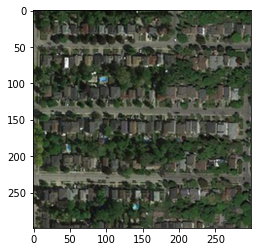

Human-annotated Caption:
 many buildings and many green trees are in a dense residential area .
Generated Caption:
 many buildings and some green trees are in a dense residential area .
BLEU score: 0.7611606003349892
_____________________________________
../../s3/valid/rsicd_resort_4.jpg


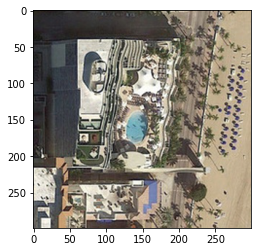

Human-annotated Caption:
 a lot of coconut trees were planted on the side of the beach .
Generated Caption:
 many buildings are around a park with many green trees and a pond .
BLEU score: 1.2395288183339461e-231
_____________________________________


In [52]:
for z in range(20):
    pic = test_paths[z]
    img_features = test_img_features[z]
    print(pic)
    x = plt.imread(pic)
    plt.imshow(x)
    plt.show()
    print("Human-annotated Caption:\n", test_descriptions[z][0])
    generated = generateCaption(img_features)
    print("Generated Caption:\n", generated)
    print("BLEU score:", 
          bleu_score.sentence_bleu([test_descriptions[z][0].split()], generated.split()))

    print("_____________________________________")

In [53]:
# generate results
results = {}
for n in range(len(test_paths)):
    pic = test_paths[n]
    # note the filename splitting depends on path
    filename = pic.split('/')[4]
    img_features = test_img_features[n]
    generated = generateCaption(img_features)
    results[filename] = generated

In [54]:
# save the results 
tag = '111_inc'
with open(f'{root_captioning}/dq_notebooks/test_results_n{tag}.json', 'w') as fp:
    json.dump(results, fp)